First I import libraries for posterior use

In [1]:
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.ensemble  import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
%matplotlib inline

#For this work i've drawn some ideas and techniques from https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
#mostly techiniques in datacleaning

#### Importing the data set

In [2]:
dtrain = pd.read_csv('train.csv')
dtest = pd.read_csv('test.csv')

In [3]:
dtrain.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
458,459,70,RM,NaN,5100,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2008,WD,Normal,161000
351,352,120,RL,NaN,5271,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Abnorml,190000
1426,1427,60,RL,81.0,10944,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,271000
481,482,20,RL,72.0,11846,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2006,WD,Normal,374000
359,360,60,RL,78.0,12011,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,280000
733,734,20,RL,80.0,10000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,Shed,400,3,2009,WD,Normal,131400
1063,1064,30,RM,50.0,6000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2006,WD,Normal,110500
648,649,60,RL,70.0,7700,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,155000
903,904,20,RL,50.0,14859,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2006,New,Partial,240000
1107,1108,60,RL,168.0,23257,Pave,NaN,IR3,HLS,AllPub,...,0,NaN,NaN,NaN,0,9,2006,New,Partial,274725


#### Data cleaning

Join the datasets in order to do the datacleaning jointly, moreover it is needed when doing hot-encoding for categorical variables since some variables do not appear on both sets

In [4]:
strain = dtrain.shape[0]
stest = dtest.shape[0]
joint = pd.concat((dtrain, dtest))
joint.drop(columns={'SalePrice'},inplace= True)
joint.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


Look for NaN values in percentage

In [5]:
totaln = joint.shape[0]
def cjoint():
    print((((joint.isnull().sum().where((joint.isnull().sum() != 0) == True).dropna())/totaln)*100).sort_values(ascending=False))
cjoint()

PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
FireplaceQu     48.646797
LotFrontage     16.649538
GarageQual       5.447071
GarageCond       5.447071
GarageFinish     5.447071
GarageYrBlt      5.447071
GarageType       5.378554
BsmtExposure     2.809181
BsmtCond         2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrType       0.822199
MasVnrArea       0.787941
MSZoning         0.137033
BsmtFullBath     0.068517
BsmtHalfBath     0.068517
Utilities        0.068517
Functional       0.068517
Electrical       0.034258
BsmtUnfSF        0.034258
Exterior1st      0.034258
Exterior2nd      0.034258
TotalBsmtSF      0.034258
GarageArea       0.034258
GarageCars       0.034258
BsmtFinSF2       0.034258
BsmtFinSF1       0.034258
KitchenQual      0.034258
SaleType         0.034258
dtype: float64


Loking at the data description we realize that NaN values stand for "lack of" for some of them. Therefore, I change NaN for Not when needed


In [6]:
joint.drop(columns={'Id'},inplace=True)

In [7]:
for label in ('Alley','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','BsmtQual','BsmtCond',
              'MiscFeature','PoolQC','BsmtExposure','BsmtFinType1','BsmtFinType2','Fence','MasVnrType'):
    joint[label] = joint[label].fillna('Not')

Now we look for the remaining NaN entries

In [8]:
cjoint()

LotFrontage     16.649538
GarageYrBlt      5.447071
MasVnrArea       0.787941
MSZoning         0.137033
Utilities        0.068517
BsmtFullBath     0.068517
BsmtHalfBath     0.068517
Functional       0.068517
Exterior1st      0.034258
BsmtFinSF2       0.034258
BsmtUnfSF        0.034258
Electrical       0.034258
GarageArea       0.034258
Exterior2nd      0.034258
TotalBsmtSF      0.034258
GarageCars       0.034258
KitchenQual      0.034258
SaleType         0.034258
BsmtFinSF1       0.034258
dtype: float64


For LotFrontage we will assume that the properties with missing values have the median LotFrontage of the neighborhood

In [9]:
#First divide the data in chunks depending on Neigh.. Then I take the category in wich we are interested
#Finally for every group "x" i apply the fillna method within the group filling na with the group median
joint['LotFrontage'] = joint.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median())) 

In [10]:
cjoint()

GarageYrBlt     5.447071
MasVnrArea      0.787941
MSZoning        0.137033
Utilities       0.068517
BsmtFullBath    0.068517
BsmtHalfBath    0.068517
Functional      0.068517
GarageCars      0.034258
GarageArea      0.034258
TotalBsmtSF     0.034258
Exterior2nd     0.034258
Exterior1st     0.034258
Electrical      0.034258
BsmtUnfSF       0.034258
KitchenQual     0.034258
SaleType        0.034258
BsmtFinSF2      0.034258
BsmtFinSF1      0.034258
dtype: float64


For GarageYrBlt, GarageArea , GarageCars we fill them with 0. We do the same for MasVnrArea , BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath. They are numerical variables where the NaN represents a zero.

In [11]:
for label in ('GarageYrBlt', 'GarageArea' , 'GarageCars', 'MasVnrArea' , 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
              'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    joint[label] = joint[label].fillna(0)

In [12]:
cjoint()

MSZoning       0.137033
Utilities      0.068517
Functional     0.068517
SaleType       0.034258
KitchenQual    0.034258
Exterior2nd    0.034258
Exterior1st    0.034258
Electrical     0.034258
dtype: float64


In [13]:
#Fill with mode by neighborhood
joint['MSZoning'] = joint.groupby('Neighborhood')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
joint['Functional'] = joint['Functional'].fillna('Typical')
joint['SaleType'] = joint.groupby('Neighborhood')['SaleType'].transform(lambda x: x.fillna(x.mode()[0]))
joint['KitchenQual'] = joint.groupby('Neighborhood')['KitchenQual'].transform(lambda x: x.fillna(x.mode()[0]))
joint['Exterior2nd'] = joint.groupby('Neighborhood')['Exterior2nd'].transform(lambda x: x.fillna(x.mode()[0]))
joint['Exterior1st'] = joint.groupby('Neighborhood')['Exterior1st'].transform(lambda x: x.fillna(x.mode()[0]))
joint['Electrical'] = joint.groupby('Neighborhood')['Electrical'].transform(lambda x: x.fillna(x.mode()[0]))

In [14]:
#Drop Utilities 
#Reason? 
print(joint['Utilities'].value_counts()) #Same value for all properties except one -> Virtually no predictive power
joint.drop(columns={'Utilities'},inplace=True)

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64


### Data visualization

Distribution of the variable of interest -> It appears to be close to a normal distribution.

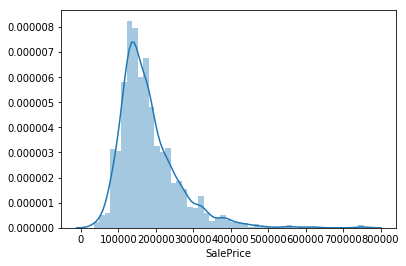

In [15]:
sns.distplot(dtrain.SalePrice)

Time trend in Sale Price:
It appears to be a slighlty decreasing trend, both in mean and median of SalePrices. However we got large dispersion of SalePrices for all years, this could mean little explanatory power of the variable YrSold when trying to explain a particular SalePrice

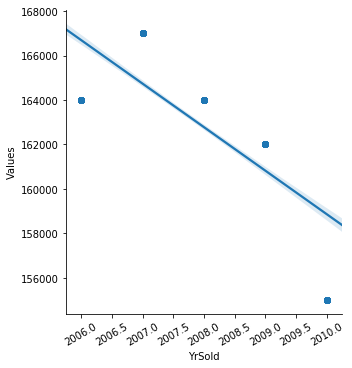

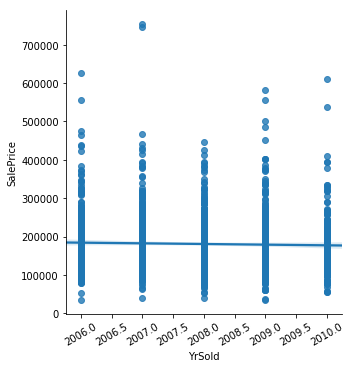

In [16]:
plot = dtrain.copy()
plot['Values'] = dtrain.groupby('YrSold')['SalePrice'].transform(lambda x: x.median())
ax = sns.lmplot(x='YrSold', y='Values',data=plot)
ax.set_xticklabels(rotation=30)
ax1 = sns.lmplot(x='YrSold', y='SalePrice',data=plot)
ax1.set_xticklabels(rotation=30)

Now I will try to look at SalePrice by LotArea, which could be one of our main explanatory variables

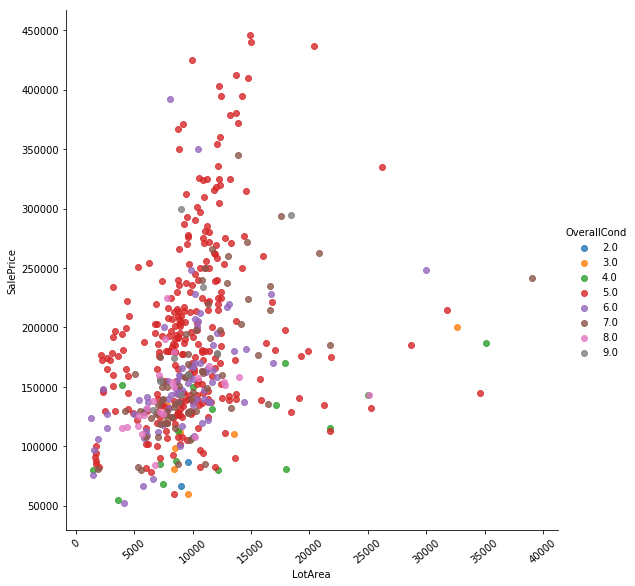

In [17]:
splot = plot.copy().sample(500).where((plot['LotArea']<40000) & (plot['SalePrice']<500000))
sns.lmplot(x='LotArea', 
                   y='SalePrice', 
                   data=splot, 
                   hue='OverallCond', fit_reg=False,height=8).set_xticklabels(rotation=40)

Finally we look at number of bedrooms, as expected it displays a posiitve effect

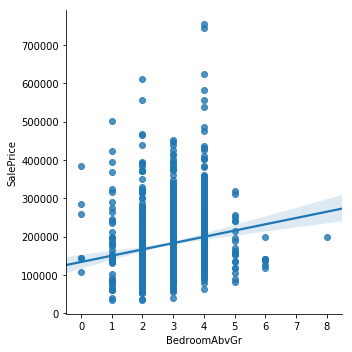

In [18]:
sns.lmplot(x='BedroomAbvGr', y='SalePrice',data=plot)

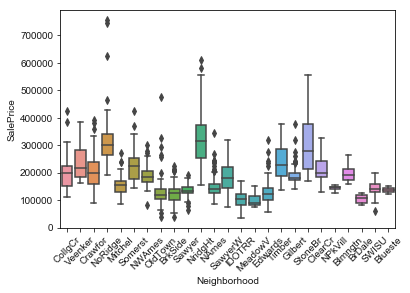

In [19]:
ax = sns.boxplot(x='Neighborhood',y='SalePrice',data=plot)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(45)
sns.set(rc={'figure.figsize':(20,20)})

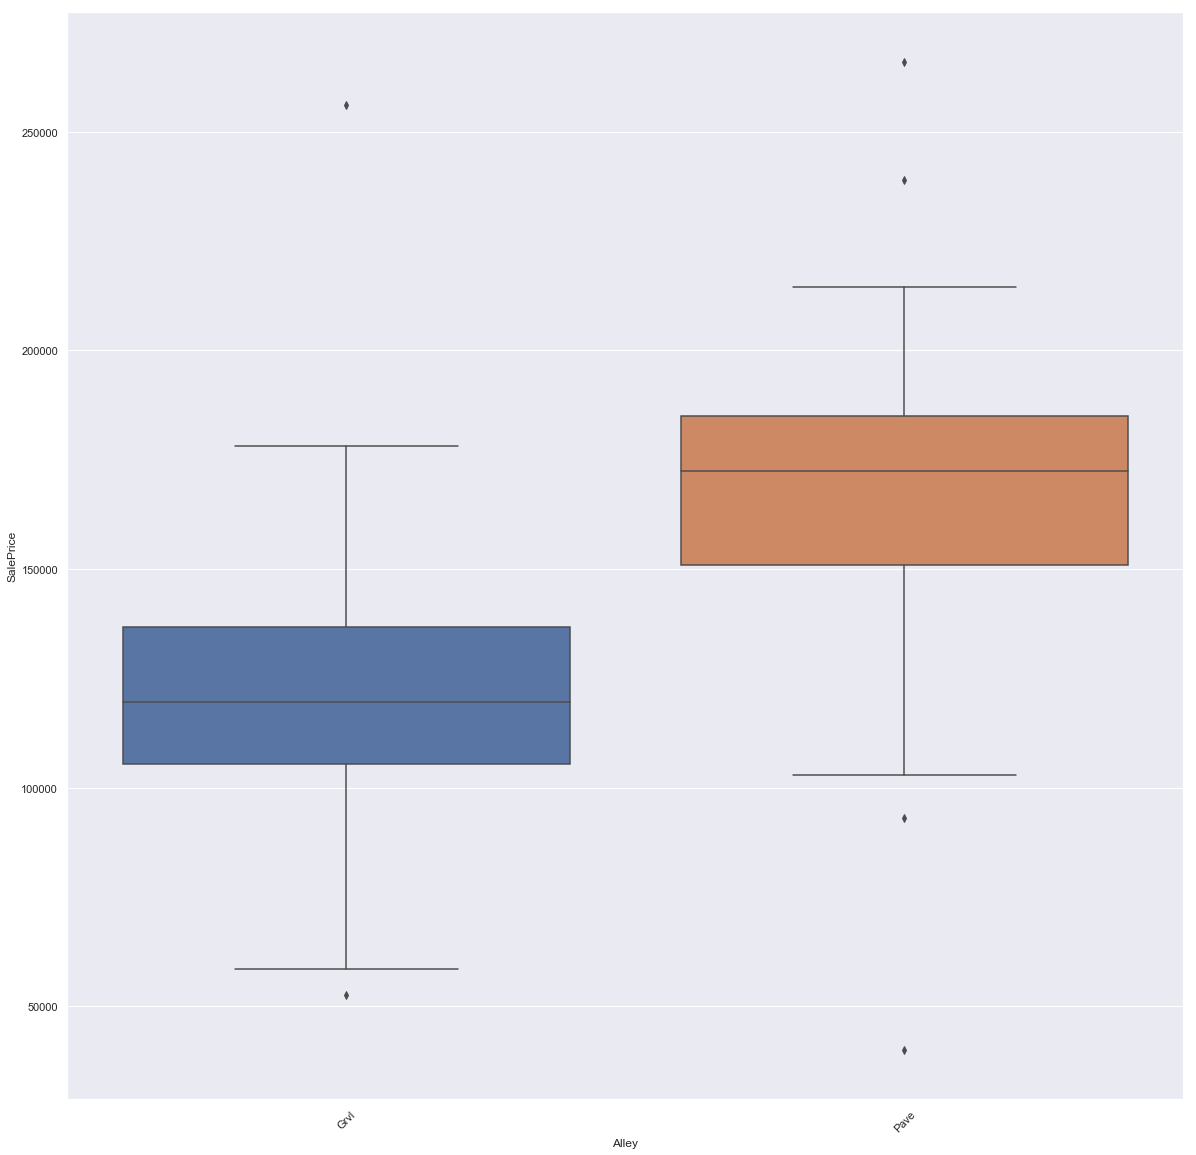

In [20]:
ax = sns.boxplot(x='Alley',y='SalePrice',data=plot)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(45)
sns.set(rc={'figure.figsize':(10,10)})

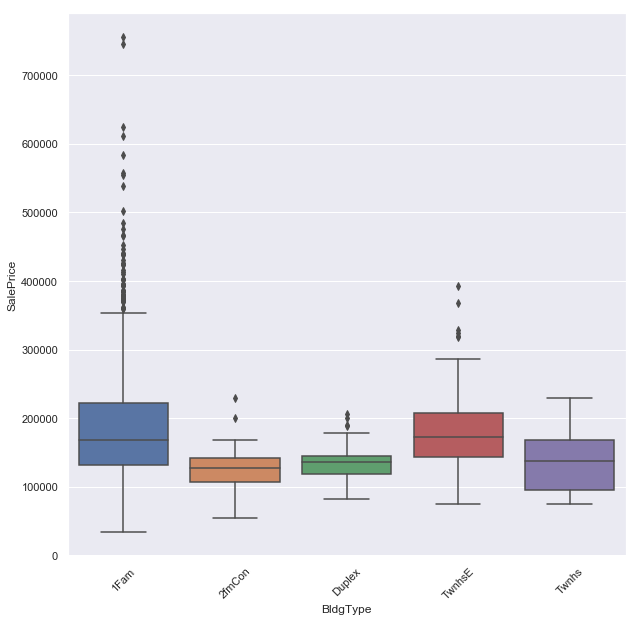

In [21]:
ax = sns.boxplot(x='BldgType',y='SalePrice',data=plot)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(45)
# sns.set(rc={'figure.figsize':(7,7)})

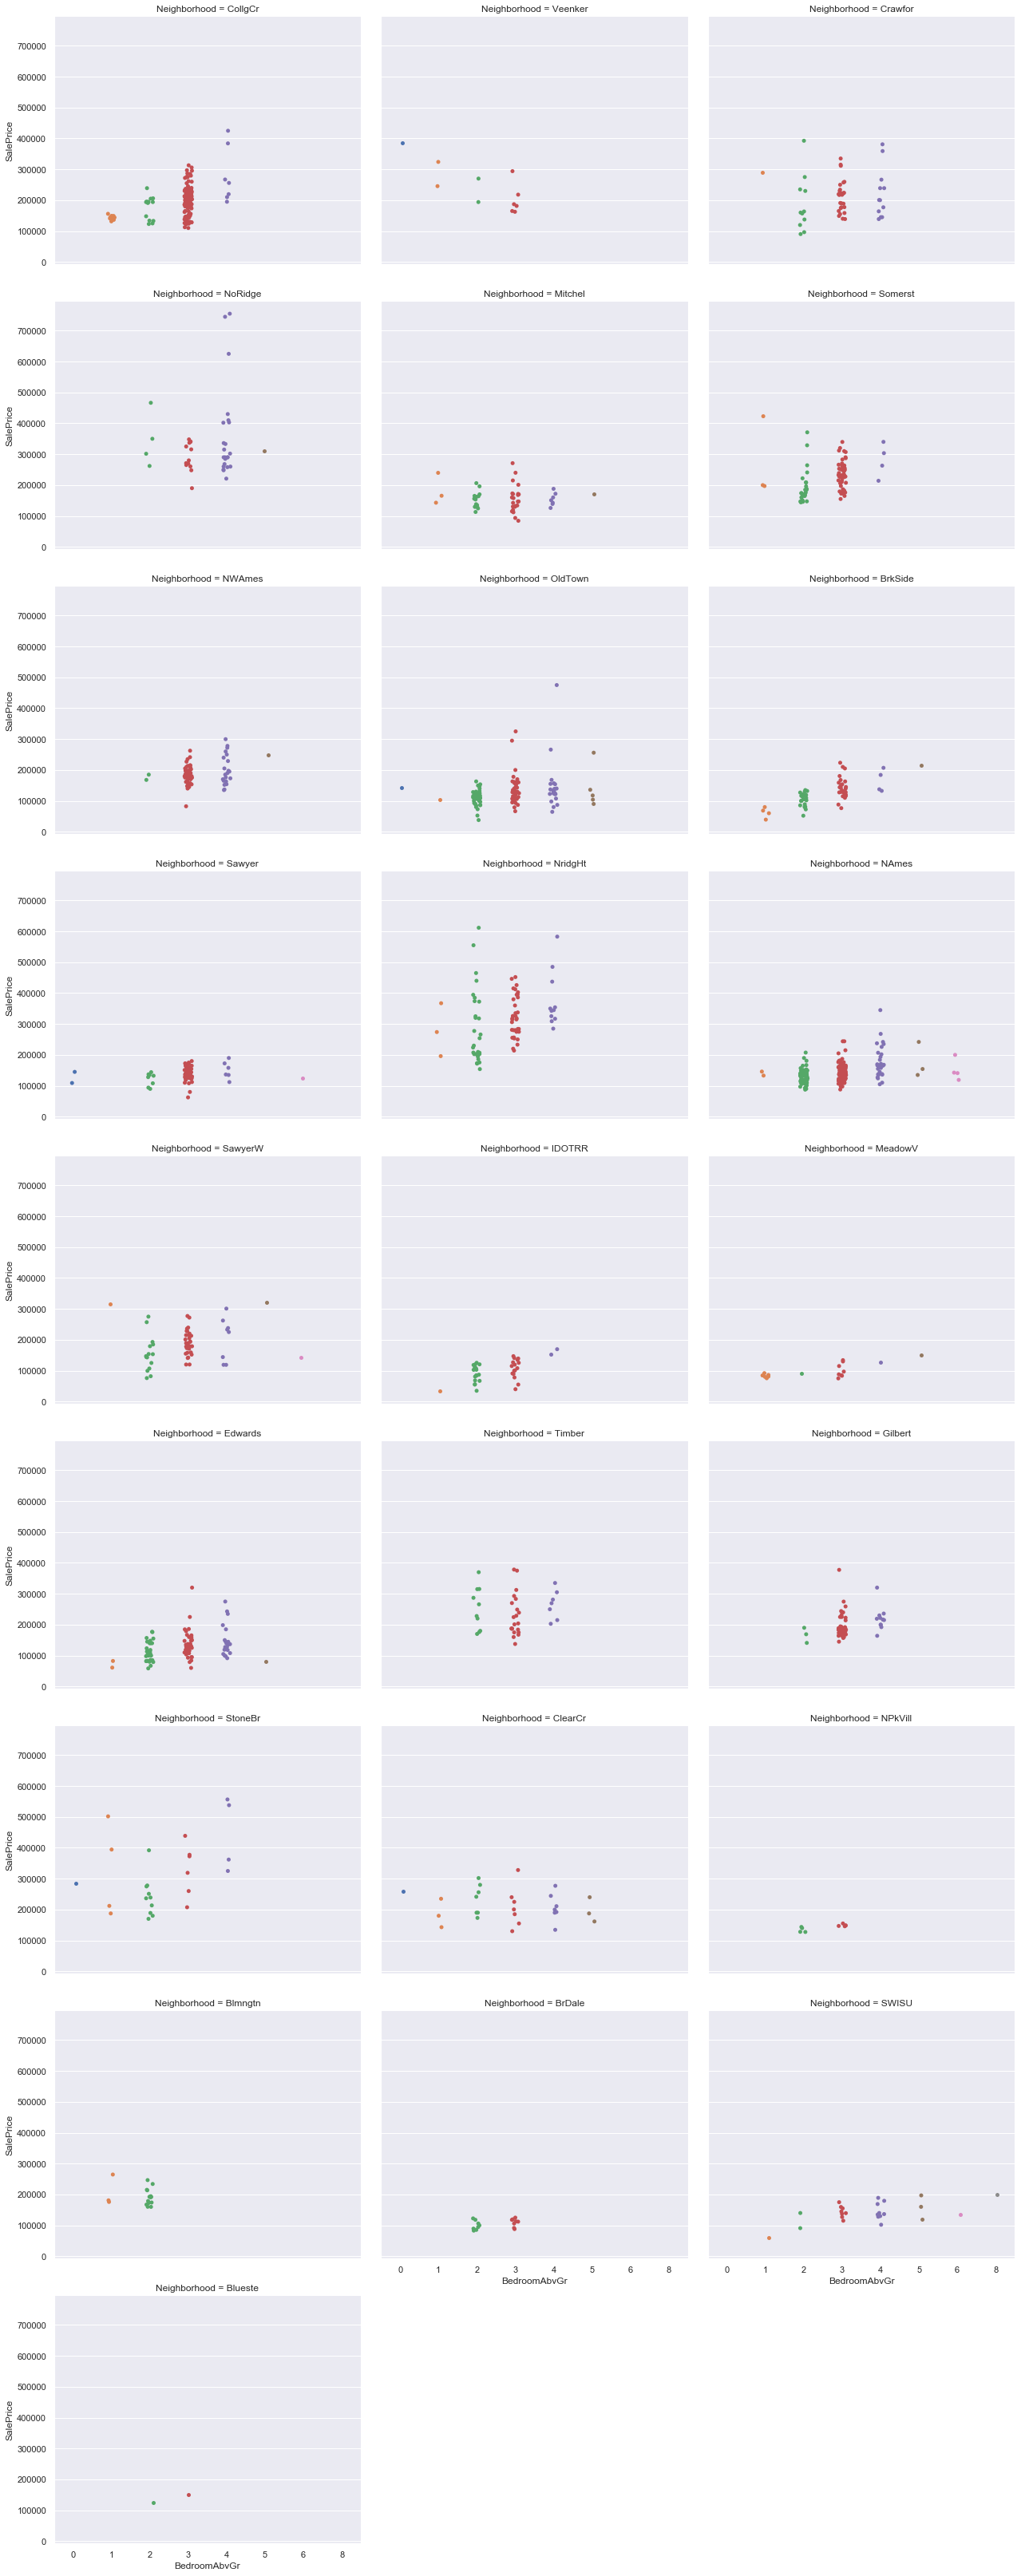

In [22]:
g = sns.catplot(x='BedroomAbvGr', y='SalePrice', col='Neighborhood', data=plot, height=5, aspect=1.2,col_wrap=3)
#For most neighborhoods the higher the number of bedrooms the higher the avg. Sale Price

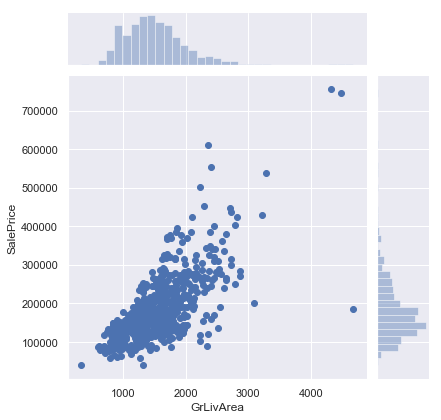

In [23]:
sns.jointplot(x='GrLivArea', y='SalePrice', data=plot.sample(700))
#More or less normal distributions for both var. Expected positive relationship

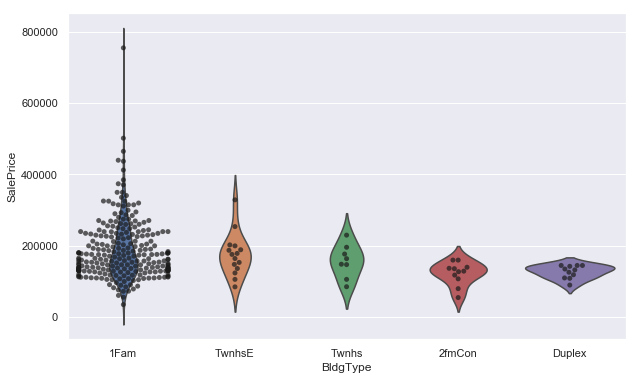

In [24]:
plot1 = plot.sample(300)
fig = plt.figure(figsize=(10,6))
sns.violinplot(x='BldgType',
               y='SalePrice', 
               data=plot1, 
               inner=None) # Remove the bars inside the "violins"
 
sns.swarmplot(x='BldgType', 
              y='SalePrice', 
              data=plot1, 
              color='k', # Make points black
              alpha=0.7) # and slightly transparent

#### Categorical variables encoding

Some variables are categorical in nature but are encoded using integers. I'll transform those to strings in order to be consistent with the posterior encoding.

In [25]:
for categorical in ('MSSubClass', 'OverallCond', 'YrSold', 'MoSold','YearRemodAdd','GarageYrBlt'):
    joint[categorical] = joint[categorical].astype(str)

Appproach 1: "regular" label encoding

In [26]:
LE = LabelEncoder()
hjoint = joint.copy()
catvar = []
for categorical in joint.columns:
    if joint[categorical].dtypes == 'object': #only categorical var are type object
        catvar.append(categorical)
        joint[categorical] = LE.fit_transform(joint[categorical].values)

Approach 2: hot label encoding

In [27]:
hjoint = pd.get_dummies(hjoint)

In [28]:
hjoint.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch',
       ...
       'YearRemodAdd_2006', 'YearRemodAdd_2007', 'YearRemodAdd_2008',
       'YearRemodAdd_2009', 'YearRemodAdd_2010', 'YrSold_2006', 'YrSold_2007',
       'YrSold_2008', 'YrSold_2009', 'YrSold_2010'],
      dtype='object', length=503)

Data analysis

Separation of train and test 

In [29]:
X = joint[:strain].copy()
X1 = hjoint[:strain].copy()
Y = dtrain['SalePrice']
x_train, x_dev, y_train, y_dev = train_test_split(X, Y, test_size=0.25)
x1_train, x1_dev, y1_train, y1_dev = train_test_split(X1, Y, test_size=0.25)

In [30]:
print('\033[1m' + 'Model1')
lr = LinearRegression().fit(x_train,y_train)
print('\033[0m'+'R^2 is    ' + str(lr.score(x_dev,y_dev))) #R^2 how much does the data explain, 
#                                        variation of Y explained by X(within the linear regression realm)?
lrintercept = lr.intercept_
lrcoeficients = lr.coef_
lrsum = pd.DataFrame({'Label':x_train.columns,'Coefs':lrcoeficients}).set_index('Label')
print('\nIntercept:    ' + str(lrintercept) )
print('\nCoefs sample')
print(lrsum.sample(10))


print('\n\n'+'\033[1m'+'Model2'+'\033[0m') ##REALLY BAD, overfitting A LOT!
lr1 = LinearRegression().fit(x1_train,y1_train)
print('\033[0m'+'R^2 is    ' + str(lr1.score(x1_dev,y1_dev))) #R^2 how much does the data explain, 
#                                        variation of Y explained by X(within the linear regression realm)?
lr1intercept = lr1.intercept_
lr1coeficients = lr1.coef_
lr1sum = pd.DataFrame({'Label':x1_dev.columns,'Coefs':lr1coeficients}).set_index('Label')
print('\nIntercept:    ' + str(lr1intercept) )
print('\nCoefs sample')
print(lrsum.sample(10))

Model1
R^2 is    0.5756877550676074

Intercept:    -238592.67561430304

Coefs sample
                    Coefs
Label                    
WoodDeckSF      18.247037
LandSlope    -2435.447156
LandContour   2224.882646
LotShape      -330.812169
YrSold        -569.426964
RoofStyle     2224.054550
BsmtCond      1006.670409
Street       34688.190228
LotConfig     -291.058770
OpenPorchSF    -14.499276


Model2
R^2 is    -23945418.06208389

Intercept:    -8606468553.8758

Coefs sample
                     Coefs
Label                     
ExterQual    -11761.764042
GarageCars     3322.479603
BsmtFinSF2       -1.083660
BsmtUnfSF        -0.577660
PoolQC       -76567.975430
CentralAir    -3193.787163
HouseStyle     -894.741299
GarageCond     1613.207390
FireplaceQu   -1136.246751
BsmtHalfBath   2612.410195


GBR

In [31]:
gbr = GradientBoostingRegressor(loss='ls',learning_rate=0.01,n_estimators =5000)
mgbr = gbr.fit(x_train,y_train)
predictions = mgbr.predict(x_dev)
score = mgbr.score(x_dev,y_dev)

gbr1 = GradientBoostingRegressor(loss='ls',learning_rate=0.01,n_estimators =5000)
mgbr1 = gbr1.fit(x1_train,y1_train)
predictions1 = mgbr1.predict(x1_dev)
score1 = mgbr1.score(x1_dev,y1_dev)

In [32]:
print('\n\n'+'\033[1m'+'Model1'+'\033[0m')
print(pd.DataFrame({'Y': y_dev, 'Predictions':np.around(predictions,decimals=2)}).sample(10))
print(str(score))
print('\n\n'+'\033[1m'+'Model2'+'\033[0m')
print(pd.DataFrame({'Y': y1_dev, 'Predictions1':np.around(predictions,decimals=2)}).sample(10))
print(str(score1))



Model1
      Predictions       Y
1132    128504.15  117500
849     189986.98  187000
1274    133443.29  139000
512     125856.19  129900
1338    225932.72  200000
684     205435.52  221000
324     255270.51  242000
591     438544.33  451950
1116    195707.09  184100
44      140007.76  141000
0.8837032932195895


Model2
      Predictions1       Y
765      234121.30  264132
1076     169753.33  170000
75       172813.77   91000
670      116249.82  173500
481      124611.78  374000
1177     100556.96  115000
655      253558.09   88000
7        105614.05  200000
109      116731.77  190000
324      163051.27  242000
0.9021174158534172


Now we should tune our model using the test data. However, since the data comes from a kaggle competition we do not have data for the Y of the test set. 